In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from kAugmentations.kRotation import *
from kAugmentations.kBrightness import *
from kAugmentations.kShearX import *
from kAugmentations.kTranslateX import *
from kAugmentations.kContrast import *

from kAugmentations.kRandRotation import *

from SingleAugmentationConfig import *
from MultiAugmentationManager import MultiAugmentationManager

import shutil

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

%matplotlib inline

/home/tom/anaconda3/envs/DADA/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### --- Config --- ###
augmentation_name = 'rotation'
main_parameter_name = 'angle'
aug_bounds = (-360., 360.)
param_linspace = np.linspace(aug_bounds[0],aug_bounds[1],400)

# dataset
target_param_val = (20.,30.)
target_aug_constructor = K.augmentation.RandomRotation
target_aug_constructor_args = {
    'degrees': torch.Tensor(target_param_val),
    'p': 1
}

kAugmentation = kRotation
init_param_val = 0.0

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.container.ImageSequential(
        target_aug_constructor(**target_aug_constructor_args)
    )
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

In [4]:
x = dataset[0][0].detach().to('cpu')

In [5]:
rotation_trans = kRotation(torch.tensor(10.))

In [6]:
def plot_t(t):
    plt.imshow(np.array(t.permute(1,2,0).detach()))

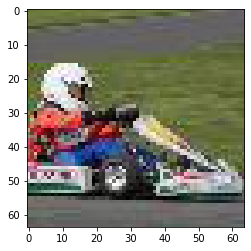

In [7]:
plot_t(x)

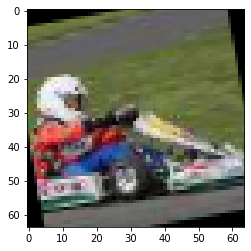

In [8]:
plot_t(rotation_trans(x.unsqueeze(0)).squeeze(0))

In [9]:
from wrappers import DUniform

rand_rotate_trans = DUniform(d_transfrom_class=kRotation, bounds=(0.,180.))

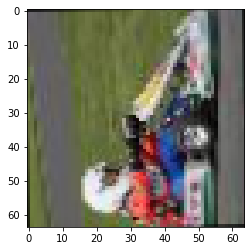

In [10]:
plot_t(rand_rotate_trans(x.unsqueeze(0)).squeeze(0))

In [11]:
for name, param in rand_rotate_trans.named_parameters():
    if param.requires_grad:
        print(name, param.data)

learned_bounds tensor([  0., 180.])


In [12]:
from wrappers import DGumbel

In [13]:
rotate = kRotation(init_param=torch.tensor([45.], requires_grad=True))
brightness = kBrightness(init_param=torch.tensor([.5], requires_grad=True))

gumbel_trans = DGumbel([rotate, brightness]).to('cuda')

In [14]:
plot_t(rotate(x.unsqueeze(0)).squeeze(0))

ValueError: Inputs must have same device Got center (cpu, torch.float32), angle (cuda:0, torch.float32) and scale (cpu, torch.float32)

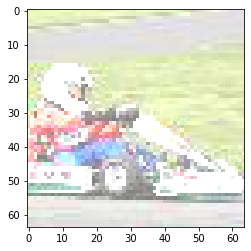

In [ ]:
plot_t(brightness(x.unsqueeze(0)).squeeze(0))

In [15]:
plot_t(gumbel_trans(x.to('cuda').unsqueeze(0)).squeeze(0))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
next(gumbel_trans.parameters()).is_cuda

True

In [17]:
krotate, kbright = gumbel_trans.d_transfrom_class_list
krotate, kbright

(kRotation(), kBrightness())

In [18]:
next(krotate.parameters()).is_cuda

True

In [19]:
next(kbright.parameters()).is_cuda


True